In [35]:
import torch
import torchvision
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.autograd import variable
from torchvision import datasets,transforms,models
import os
import numpy as np


In [20]:
# data transformation
transforms={
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) 
    ]),
}

In [21]:
## loading dataset
data_directory='data\hymenoptera_data'
# create a dict of image info
image_dataset={x: datasets.ImageFolder(os.path.join(data_directory,x),transforms[x]) for x in ['train','val']}
# create a iterable data loader
data_loader={x: torch.utils.data.DataLoader(image_dataset[x],batch_size=4,shuffle=True) for x in ['train','val']}
# get class names
classes=image_dataset['train'].classes
print('total train images :',len(image_dataset['train']))
print('total test images :',len(image_dataset['val']))
print('total batches in train :',len(data_loader['train']))
print('total batches in test :',len(data_loader['val']))
print('class names',classes)

total train images : 244
total test images : 153
total batches in train : 61
total batches in test : 39
class names ['ants', 'bees']


In [24]:
image_dataset['train']


Dataset ImageFolder
    Number of datapoints: 244
    Root location: data\hymenoptera_data\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [25]:
# loading resnet model
model=torchvision.models.resnet18(pretrained=True)


e:\DeepLearning\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\DeepLearning\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [27]:
#freze layers
for param in model.parameters():
    param.requires_grad=False
    

In [28]:
input_features=model.fc.in_features
# reconstruct the last layer to have only two output classes
model.fc=nn.Linear(input_features,2)

In [29]:
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=1e-2,momentum=0.9)
ex_lr_scheular=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

In [30]:
train_loss=[]
training_accuracy=[]
test_loss=[]
testing_accuracy=[]


In [32]:
epochs=10
for epoch in range(epochs):
    ex_lr_scheular.step()
    iter_loss=0
    correct=0
    iterations=0
    model.train()
    for i,(images,labels) in enumerate(data_loader['train']):
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        iter_loss+=loss.item()
        loss.backward()
        optimizer.step()
        _,predicted_value=torch.max(outputs,1)
        correct+=(predicted_value==labels).sum()
        iterations+=1
    train_loss.append(iter_loss/iterations)
    training_accuracy.append(100* correct/len(image_dataset['train']))
    iter_loss=0
    correct=0
    iterations=0
    model.eval()

    for i,(images,labels) in enumerate(data_loader['val']):
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        iter_loss+=loss.item()
        _,predicted_value=torch.max(outputs,1)
        correct+=(predicted_value==labels).sum()
        iterations+=1
    test_loss.append(iter_loss/iterations)
    testing_accuracy.append(100* correct/len(image_dataset['val']))
    print('epoch : {}/{}, training loss={},training accuracy={:.3f},test_loss={},test_accuracy={:.3f}'.format(epoch+1,epochs,train_loss[-1],training_accuracy[-1],
    test_loss[-1],testing_accuracy[-1]))



epoch : 1/10, training loss=2.3100278522462636,training accuracy=77.049,test_loss=3.9114701467864483,test_accuracy=70.588
epoch : 2/10, training loss=2.0330619119500226,training accuracy=79.098,test_loss=0.8577158258550158,test_accuracy=92.810
epoch : 3/10, training loss=1.1457268614209986,training accuracy=86.885,test_loss=0.9620400224240107,test_accuracy=92.810
epoch : 4/10, training loss=2.631267009480163,training accuracy=76.639,test_loss=0.7587221932045586,test_accuracy=94.118
epoch : 5/10, training loss=3.0228021673114314,training accuracy=72.131,test_loss=4.959013860073179,test_accuracy=69.935
epoch : 6/10, training loss=2.3234143649122063,training accuracy=80.328,test_loss=0.7335733860907706,test_accuracy=94.118
epoch : 7/10, training loss=1.3823849551633458,training accuracy=84.836,test_loss=0.8353069040304043,test_accuracy=93.464
epoch : 8/10, training loss=1.0824821705866092,training accuracy=85.246,test_loss=0.8925682663007509,test_accuracy=93.464
epoch : 9/10, training los

In [39]:
import matplotlib.pyplot as plt

true label:ants
true label:bees
true label:bees
true label:bees


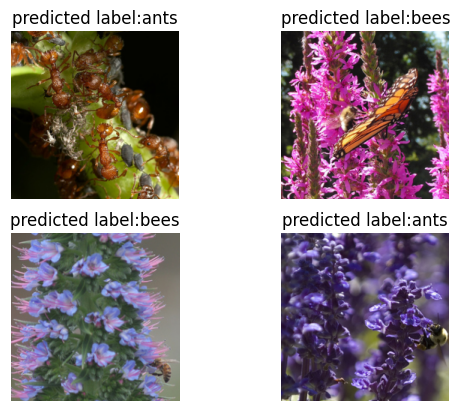

In [46]:
#     Visualizing some images and predictions
fig=plt.figure()
shown=0
index=0
with torch.no_grad():
    for i,(images,labels ) in enumerate (data_loader['val']):
        if shown==1:
            break
        shown+=1
        outputs=model(images)
        _,predicted_value=torch.max(outputs,1)
        for i in range(4):
            index+=1
            ax=plt.subplot(2,2,index)
            ax.axis('off')
            print('true label:{}'.format(classes[labels[i]]))            
            ax.set_title('predicted label:{}'.format(classes[predicted_value[i]]))
            image=images.data[i]
            image=image.numpy().transpose((1,2,0))
            mean=np.array([0.485, 0.456, 0.406])
            std=np.array([0.229, 0.224, 0.225])
            image=std*image+mean
            image=np.clip(image,0,1)
            plt.imshow(image)

    